# Model Selection
Evaluating and selecting algorithms and hyperparameters.

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Evaluating models
To know whether we can _trust_ what our algorithm has learned, we need to evaluate it.

We will focus on supervised methods (classification and regression)
- With the labels we can objectively evaluate models
- There are still many ways to do this

In unsupervised learning (e.g. clustering) we don't know what the 'right' output should be
- We can only optimize for certain properties (e.g. cluster purity)
- Ultimately, we need to inspect results manually (or create an external evaluation measure)

## The holdout (simple train-test split)
We've already seen the most basic form of evaluation:

- Split data into training and test set (75%-25%)
    - In sklearn we split in training and test predictors (X_train, X_test) and labels (y_train, y_test)
- Train (fit) a model on the training data
- Score a model on the test data (comparing predicted and true labels)
    - We are interested in how well the model _generalizes_ to new (test) data

In [7]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(centers=2, random_state=0)
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Instantiate a model and fit it to the training set
lr = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Test set score: 0.92


Visualized

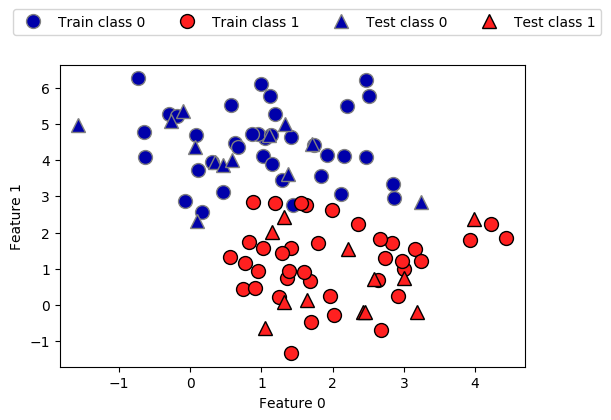

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                         markers='o', ax=ax)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                         markers='^', ax=ax)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.legend(["Train class 0", "Train class 1", "Test class 0",
                "Test class 1"], ncol=4,  loc=(-0.1, 1.1));

Limitations to this approach:

* Why 75%? Are there better ways to split?
* What if one random split yields different models (and scores) than another?
* What if all examples of one class all end up in the training/test set?

## Cross-validation

- More stable, thorough way to estimate generalization performance
- _k-fold cross-validation_ (CV): split (randomized) data into _k_ equal-sized parts, called _folds_
    - First, fold 1 is the test set, and folds 2-5 comprise the training set
    - Then, fold 2 is the test set, folds 1,3,4,5 comprise the training set
    - Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)

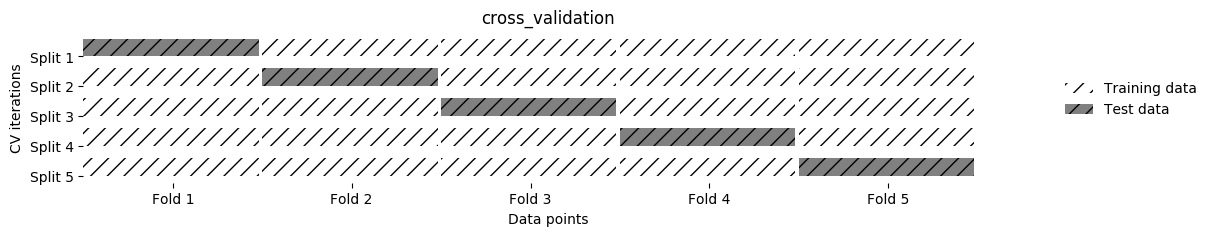

In [9]:
mglearn.plots.plot_cross_validation()

### Cross-validation in scikit-learn

- `cross_val_score` function with learner, training data, labels
- Returns list of all scores
    - Does 3-fold CV by default
    - Default scoring measures are accuracy (classification) or $R^2$ (regression)
- Even though models are built internally, they are not returned

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.961  0.922  0.958]


- Change the number of folds with `cv` parameter
- Note that there can be quite some _variance_ in the results
    - Depends on the stability of the model and the amount of training data
    - Typically, the more training data, the more stable the models

In [11]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross validation scores: {}".format(scores))

Cross validation scores: [ 1.     0.967  0.933  0.9    1.   ]


- Aggregate the scores yourself (e.g. mean)
- This means that the model is 96% accurate _on average_

In [12]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


### Benefits of cross-validation
- More robust: every training example will be in a test set exactly once
    - Model is evaluated on all samples, needs to do well on all
    - With a train-test split, we can be
        - 'lucky': all easy examples in test set
        - 'unlucky: all hard examples in test set
- Shows how _sensitive_ the model is to the exact training set
- Better estimation of true performance
    - 10-fold CV uses 90% of all data for training (vs 75% for holdout)
    - The higher _k_, the more accurate the estimation
- Disadvantage: computational cost, roughly _k_ times slower than holdout

### Stratified K-Fold cross-validation

- If the data is _unbalanced_, some classes have many fewer samples
- Likely that some classes are not present in the test set 
- Stratification: make sure that _proportions_ between classes are conserved in each fold
    - Order examples per class
    - Separate the samples of each class in _k_ sets (strata)
    - Combine corresponding strate into folds

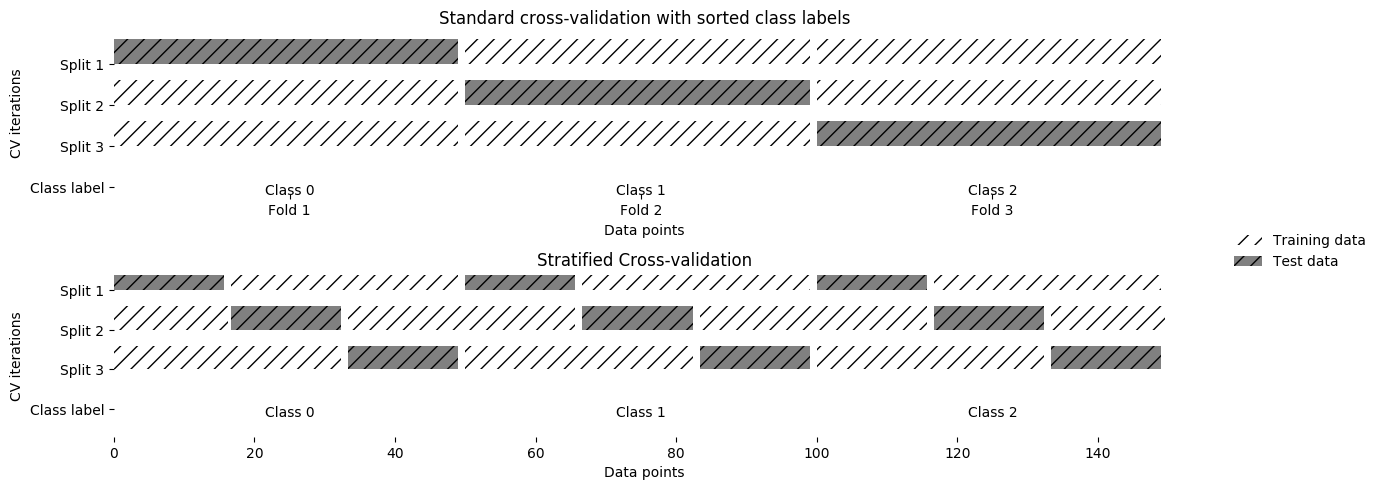

In [13]:
mglearn.plots.plot_stratified_cross_validation()

- scikit-learn will use:
    - stratified cross-validation by default for classification
    - normal cross-validation for regression
    - both are non-randomized (samples are not shuffled beforehand)
- You can build folds manually with `KFold`
    - non-randomized, non-stratified 

In [14]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[ 1.     0.933  0.433  0.967  0.433]


In [15]:
# Can you explain this result?
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[ 0.  0.  0.]


In [16]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[ 0.9   0.96  0.96]


### Leave-One-Out cross-validation

- _k_ fold cross-validation with _k_ equal to the number of samples
- Completely unbiased, but computationally expensive
- Recommended for small datasets

In [17]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


### Shuffle-Split cross-validation

- Samples a number of samples (`train_size`) randomly as the training set, and a disjoint number of samples (`test_size`) as the test set
- Repeat this procedure `n_iter` times, obtaining `n_iter` scores
- Typically, the whole dataset is used each iteration (except for large datasets)
- Example with `train_size` = 10, `test_size` = 2, `n_iter` = 4

![shuffle_split](images/03_shuffle_split.png)

- In scikit-learn, `train_size` and `test_size` can be absolute numbers or a percentage of the total dataset
- Stratified variant: `StratifiedShuffleSplit' (recommended for classification)

In [18]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[ 0.987  0.907  0.96   0.92   0.933  0.773  0.987  0.787  1.     0.92 ]


Note: this is related to _bootstrapping_:
- Sample _n_ (total number of samples) data points, with replacement, as training set (the bootstrap)
- Use the unsampled (out-of-bootstrap) samples as the test set
- Repeat `n_iter` times, obtaining `n_iter` scores
- Not supported in scikit-learn, use Shuffle-Split instead.
    - With `train_size=0.66`, `test_size=0.34`
    - You can prove that bootstraps include 66% of all data points on average 

### Repeated cross-validation
- Cross-validation is still biased in that the initial split can be made in many ways
- Repeated, or n-times-k-fold cross-validation:
    - Shuffle data randomly, do k-fold cross-validation
    - Repeat n times, yields n times k scores
- Unbiased, very robust, but n times more expensive

### Cross-validation with groups

- Sometimes the data contains inherent groups:
    - Blood analysis results on specific patients
    - Facial expressions of specific people
- With normal cross-validation, data from the same persion may end up in the training _and_ test set
- If we want to measure how well the model generalizes to _other_ people, this is undesirable
- We want to make sure that data points fom one person are in _either_ the training or test set
    - This is called _grouping_ or _blocking_
    - Leave-one-subject-out cross-validation: create test set for each user individually

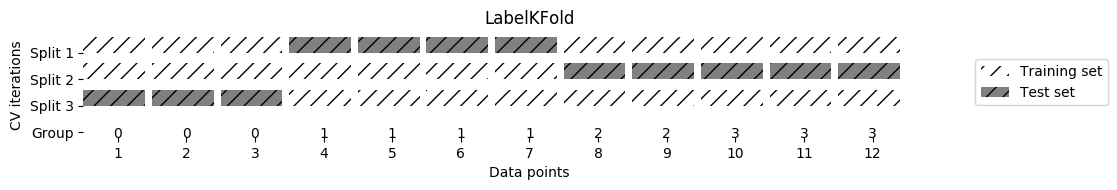

In [19]:
mglearn.plots.plot_group_kfold()

- In scikit-learn, this is supported by `GroupKFold`
    - Add an array with group membership to `cross_val_scores` 
    - Use `GroupKFold` with the number of groups as CV procedure

In [20]:
from sklearn.model_selection import GroupKFold
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[ 0.75   0.8    0.667]


### Choosing a performance estimation procedure
No strict rules, only guidelines:

- Always use stratification for classification
- Use holdout for very large datasets (e.g. >1.000.000 examples)
    - Or when learners don't always converge (e.g. deep learning)
- Choose _k_ depending on dataset size and resources
    - Use leave-one-out for small datasets (e.g. <500 examples)
    - Use cross-validation otherwise
        - Most popular (and theoretically sound): 10-fold CV
        - Literature suggests 5x2-fold CV is better
- Use grouping or leave-one-subject-out for grouped data

## Bias-Variance decomposition

- When we repeat evaluation procedures multiple times, we can distinguish two sources of errors:
    - Bias: systematic error (independent of the training sample). The classifier always gets certain points wrong
    - Variance: error due to variability of the model with respect to the training sample. The classifier predicts some points accurately on some training sets, but inaccurately on others.
- There is also an intrinsic (noise) error, but there's nothing we can do against that.
- Bias is associated with underfitting, and variance with overfitting
- Bias-variance trade-off: you can often exchange bias for variance through (de)regularization
    - The challenge is to find the right trade-off (minimizing total error)
- Useful to understand how to tune or adapt learning algorithm

- Sadly, this is not yet supported by scikit-learn
- How to measure bias and variance (for regression):
    - Take 100 or more bootstraps (or shuffle-splits)
    - For each data point x:
        - $bias(x) = (x_{true} - mean(x_{predicted}))^2$
        - $variance(x) = var(x_{predicted})$
    - Total bias: $\sum_{x} bias(x) * w_x$, with $w_x$ the ratio of x occuring in the test set
    - Total variance: $\sum_{x} variance(x) * w_x$

![Bias-variance](images/03_bias_variance.png)

- General procedure for (binary) classification:
    - Take 100 or more bootstraps (or shuffle-splits)
    - Bias for any point x = misclassification ratio
        - If misclassified 50% of the time: $bias(x)=0.5$
    - Variance for any point x is $(1 - (P(class_1)^2 + P(class_2)^2))/2$
        - $P(class_i)$ is ratio of class $i$ predictions
        - When each class predicted half of the time: $variance(x) = (1-(0.5^2+0.5^2))/2 = 0.25$
    - Total bias: $\sum_{x} bias(x)^2 * w_x$, with $w_x$ the ratio of x occuring in the test data
    - Total variance: $\sum_{x} variance(x) * w_x$

In [34]:
# Data and classifier
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)
clf = LogisticRegression()

# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

# Store sample predictions
y_all_pred = [[] for _ in range(len(y))]

# Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])

    # Store predictions
    for i,index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])
        
# Compute bias, variance, error
bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(y_all_pred)])
error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

print("Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (bias_sq, var, error))

Bias squared: 14.23, Variance: 0.75, Total error: 14.98


- High bias means that you are likely underfitting
    - Do less regularization
    - Use a more flexible/complex model (another algorithm)
    - Use a bias-reduction technique (boosting)
- High variance means that you are likely overfitting
    - Use more regularization
    - Get more data
    - Use a simpler model (another algorithm)
    - Use a variance-reduction techniques (bagging)
- Boosting and Bagging will be explained later

## Hyperparameter tuning
Now that we know how to evaluate models, we can improve them by tuning their hyperparameters

We can basically use any optimization technique to optimize hyperparameters:
    
- __Grid search__
- __Random search__
- Local search
- Racing algorithms
- __Model-based optimization__
- Multi-armed bandits
- Genetic algorithms

### Grid Search

- For each hyperparameter, create a list of interesting/possible values
    - E.g. For kNN: k in [1,3,5,7,9,11,33,55,77,99]
- Evaluate all possible combination of hyperparameter values
    - E.g. using cross-validation
- Select the hyperparameter values yielding the best results

A naive approach would be to just loop over all combinations  
Note: we've seen the `C` parameter of SVMs, we'll see the `gamma` parameter later.

In [35]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C);
        svm.fit(X_train, y_train);
        # evaluate the SVC on the test set 
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'gamma': 0.001, 'C': 100}


#### Overfitting the parameters and the validation set
- Simply taking the best performing model yields optimistic results
- We've already used the test data to evaluate each hyperparameter setting
- Hence, we don't have an independent test set to evaluate these hyperparameter settings
    - Information 'leaks' from test set into the final model
- Solution: Set aside part of the training data to evaluate the hyperparameter settings
    - Select best hyperparameters on validation set
    - Rebuild the model on the training+validation set
    - Evaluate optimal model on the test set

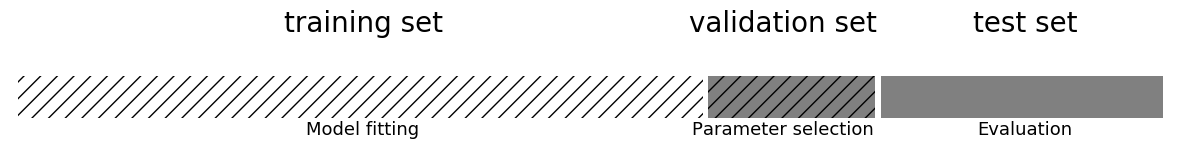

In [36]:
mglearn.plots.plot_threefold_split()

In [37]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set 
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'gamma': 0.001, 'C': 10}
Test set score with best parameters: 0.92


#### Grid-search with cross-validation

- Same problem as before: the way that we split the data into training, validation, and test set may have a large influence on estimated performance
- We need to use cross-validation again, instead of a single split
- Expensive. Often, 5-fold CV is enough, or a shuffle_split with `n_iter=1` 

In [38]:
# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Overall process

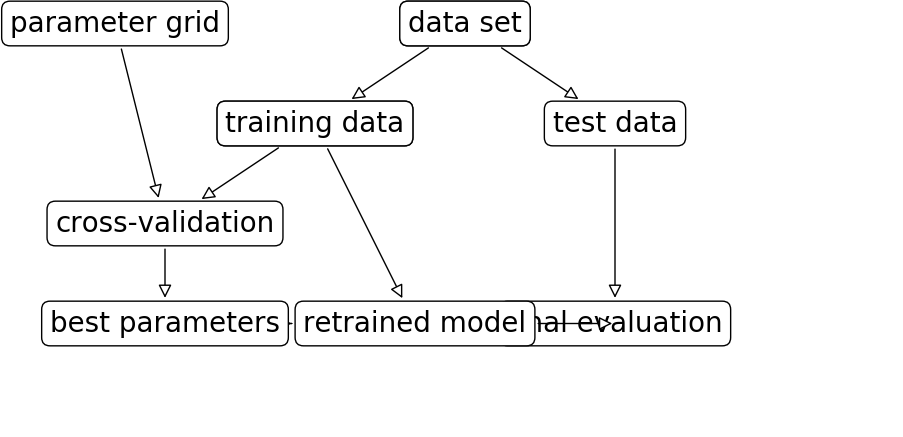

In [39]:
mglearn.plots.plot_grid_search_overview()

#### Grid search in scikit-learn
- Create a parameter grid as a dictionary
    - Keys are parameter names
    - Values are lists of hyperparameter values

In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}


- `GridSearchCV`: like a classifier that uses CV to automatically optimize its hyperparameters internally
    - Input: (untrained) model, parameter grid, CV procedure
    - Output: optimized model on given training data
    - Should only have access to trinaing data

In [41]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The optimized test score and hyperparameters can easily be retrieved:

In [42]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [43]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'gamma': 0.01, 'C': 100}
Best cross-validation score: 0.97


In [44]:
# Not really necessary because grid_search can also predict and score
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Visualizing hyperparameter impact
We can retrieve and visualize the cross-validation resulst to better understand the impact of hyperparameters

In [45]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
# Show the first 5 rows
display(results.head())

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,...,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.62e-03,8.03e-04,0.37,0.37,...,1.41e-03,9.17e-04,0.01,2.85e-03
1,1.72e-03,8.86e-04,0.37,0.37,...,5.46e-04,5.14e-04,0.01,2.85e-03
2,9.09e-04,3.46e-04,0.37,0.37,...,4.05e-04,1.39e-04,0.01,2.85e-03
3,7.22e-04,2.69e-04,0.37,0.37,...,1.20e-04,2.90e-05,0.01,2.85e-03
4,7.34e-04,2.76e-04,0.37,0.37,...,4.36e-05,1.19e-05,0.01,2.85e-03


Visualize as a heatmap

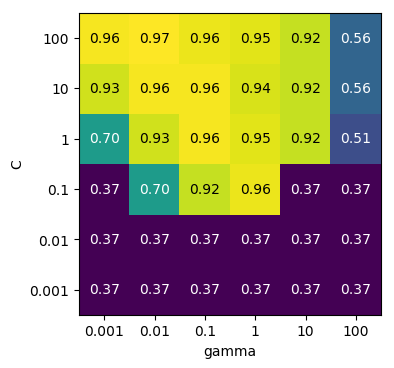

In [46]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis");

When hyperparameters depend on other parameters, we can use lists of dictionaries to define the hyperparameter space

In [47]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


#### Nested cross-validation

- Note that we are still using a single split to create the outer test set
- We can also use cross-validation here
- Nested cross-validation:
    - Outer loop: split data in training and test sets
    - Inner loop: run grid search, splitting the training data into train and validation sets
- Result is a just a list of scores
    - There will be multiple optimized models and hyperparameter settings (not returned)
- To apply on future data, we need to train `GridSearchCV` on all data again

In [48]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.967  1.     0.9    0.967  1.   ]
Mean cross-validation score:  0.966666666667


#### Parallelizing cross-validation and grid-search
- On a practical note, it is easy to parallellize CV and grid search
- `cross_val_score` and `GridSearchCV` have a `n_jobs` parameter defining the number of cores it can use.
    - set it to `n_jobs=-1` to use all available cores.

### Random Search

- Grid Search has a few downsides:
    - Optimizing many hyperparameters creates a combinatorial explosion
    - You have to predefine a grid, hence you may jump over optimal values
- Random Search:
    - Picks `n_iter` random parameter values
    - Scales better, you control the number of iterations
    - Often works better in practice, too
        - not all hyperparameters interact strongly
        - you don't need to explore all combinations

- Executing random search in scikit-learn:
    - `RandomizedSearchCV` works like `GridSearchCV`
    - Has `n_iter` parameter for the number of iterations
    - Search grid can use distributions instead of fixed lists

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112315710>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112315278>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

## Model-based optimization

- After a number of random search iterations we know more about the performance of hyperparameter settings on the given dataset
- We can use this data to train a model, and predict which other hyperparameter values might be useful
- This is often a probabilistic (e.g. Bayesian) model that predicts confidence intervals for all hyperparameter settings


Example: Bayesian optimization (see figure): 

- Consider only 1 continuous hyperparameter (X-axis)
- Y-axis shows cross-validation performance
- Evaluate a number of random hyperparameter settings (black dots)
    - Sometimes an initialization design is used
- Train a model, and predict the expected performance of other (unseen) hyperparameter values
    - Mean value (black line) and distribution (blue band)
- An _acquisition function_ (green line) trades off maximal expected performace and maximal uncertainty
    - Exploitation vs exploration
- Optimal value of the asquisition function is the next hyperparameter setting to be evaluated
- Repeat a fixed number of times, or until time budget runs out

![BayesOpt](images/03_Bayesian_optimization.png)

## Evaluation Metrics and scoring
Keep the end-goal in mind

### Metrics for binary classification

- The most common (and simple) application of machine learning in practive
- We have a positive and a negative class
- Different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- Which side do you want to err on for a medical test?

#### Imbalanced datasets

- The type of error plays an even larger role if the dataset is imbalanced
    - One class is much more frequent than the other
    - This is often typical of real world data
    - E.g. credit card fraud detection
- Is a 99.99% accuracy good enough? 

- Let's create an imbalanced dataset from the handwritten digits dataset by classifying the digit 9 against all others.
- Is 90% accuracy still good? Can we do better?

In [50]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

In [51]:
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression

# Always predicts majority class
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

dummy score: 0.90


In [52]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

logreg score: 0.98


#### Confusion matrices

- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to the true classes
    - Columns correspond to the predicted classes
    - Each entry counts how often a sample that belongs to the class corresponding to the row was classified as the class corresponding to the column.

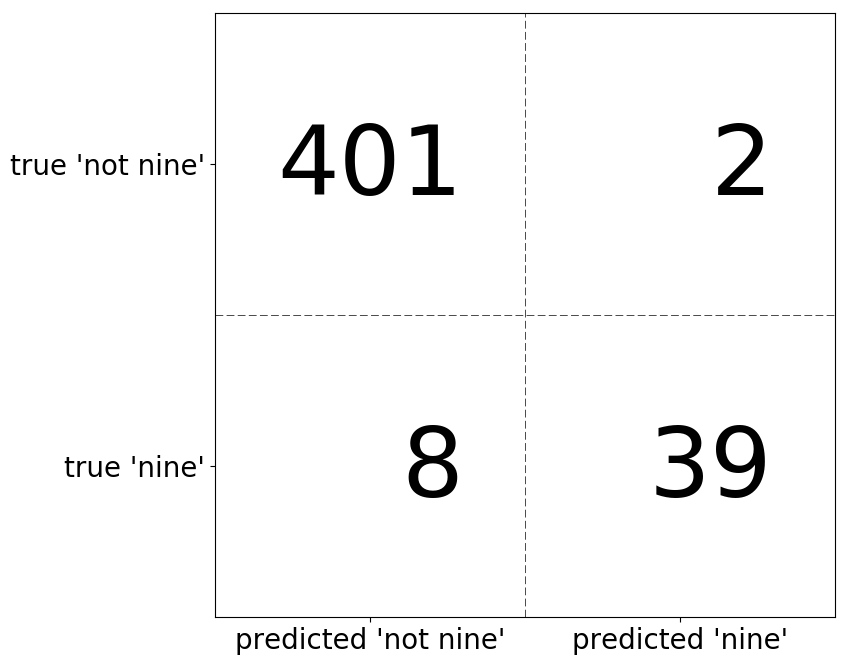

In [53]:
mglearn.plots.plot_confusion_matrix_illustration()

The confusion matrix can be constructed from the true labels and predcitions as follows:

In [54]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


For binary classification, we use the following terms:

- True Negative (TN)
- False Positive (FP)
- False Negative (FN)
- True Positive (TP)

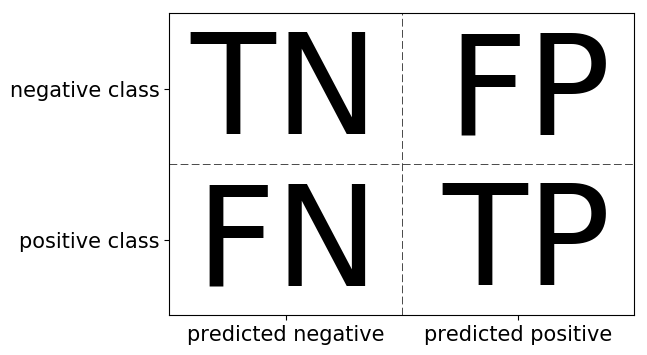

In [55]:
mglearn.plots.plot_binary_confusion_matrix()

It's often useful to compare the confusion matrices of classifiers:
- The dummy classifier always predicts the same class, produces a large number of FNs.
- Logistic regression produces more FPs, but much fewer FNs.

In [56]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_dummy))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Logistic Regression
[[401   2]
 [  8  39]]


The results of the confusion matrix can be summarized in several ways

- We already know accuracy:

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

__Precision__ is used when the goal is to limit FPs
- Clinical trails: you only want to test drugs that really work
- Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

__Recall__ is used when the goal is to limit FNs
- Cancer diagnosis: you don't want to miss a serious disease
- Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

__F1-score__ or F1-measure trades of precision and recall:

\begin{equation}
\text{F} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

In [57]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_test, pred_dummy)))
print("f1 score logistic regression: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score logistic regression: 0.89


- To study all of them at once, use `classification_report`
    - Support: number of samples in each class
    - Last line: weighted average over the classes (weighted by number of smaples in each class)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_dummy,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



In [59]:
print(classification_report(y_test, pred_logreg,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.98      1.00      0.99       403
       nine       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



#### Taking uncertainty into account

- Remember that many classifiers actually return a probability per class
    - We can retrieve it with `decision_function` and `predict_proba`
- For binary classification, we threshold at 0 for  `decision_function` and 0.5 for `predict_proba` by default
- However, depending on the evaluation measure, you may want to threshold differently to fit your goals
    - For instance, when a FP is much worse than a FN
    - This is called _threshold calibration_

##### Visualization
- Imagine that we want to avoid misclassifying a red point
- The black line shows the threshold: points within are classified positive (red)
- By changing the decision treshold, more points will be classified positive

In [60]:
from mglearn.datasets import make_blobs 
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],        
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)                                     

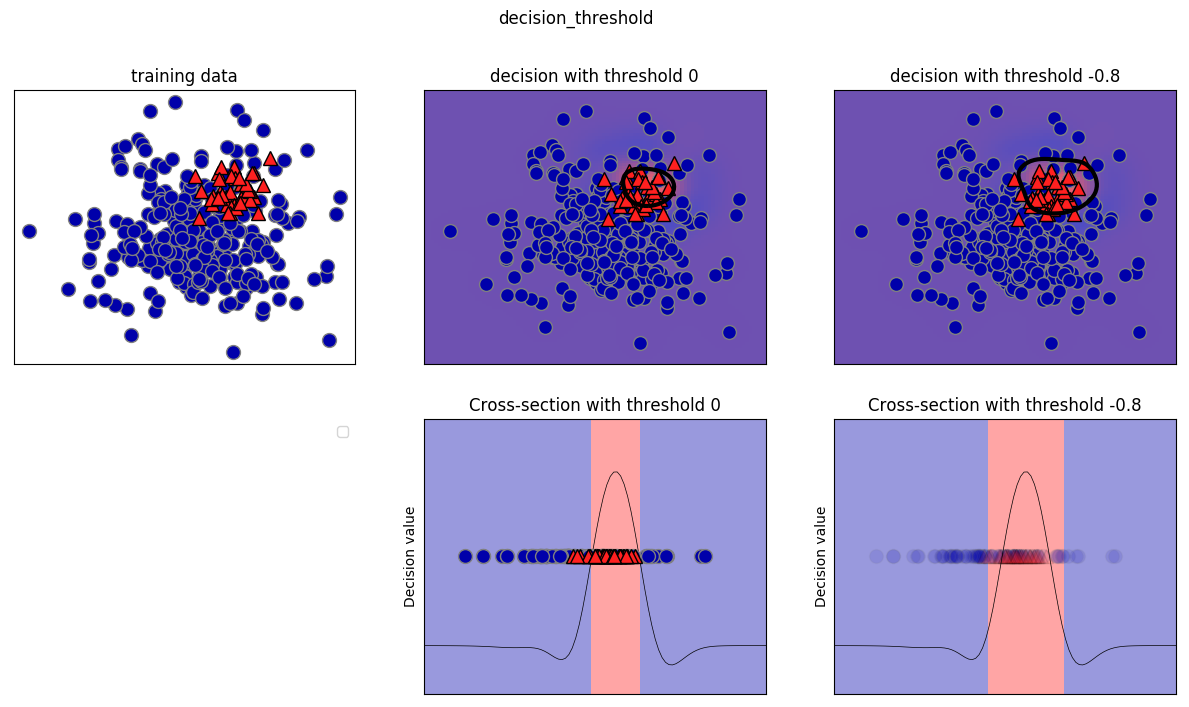

In [61]:
mglearn.plots.plot_decision_threshold()

- Studying the classification report, we see that lowering the threshold yields:
    - higher recall for class 1 (we risk more FPs in exchange for more TP)
    - lower precision for class 1
- We can often trade off precision for recall

In [62]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



In [63]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



### Precision-Recall curves

- The right threshold depends on your application, should be driven by business goals.
- You can have arbitrary high recall, but you often want reasonable precision, too.
- It is not clear beforehand where the optimale trade-off (or _operating point_) will be, so it is useful to look at all possible thresholds
- Plotting precision against recall for all thresholds yields a __precision-recall curve__
 


- In scikit-learn, this is included in the `sklearn.metrics` module
- Returns all precision and recall values for all thresholds

In [64]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

- Now we can plot the curve. The default tradeoff (chosen by the `predict` method) is indicated as _threshold zero_.
- The closer the curve stays to the upper-right corner, the better
    - High precision and high recall
- Here, it is possible to still get a precision of 0.5 with high recall

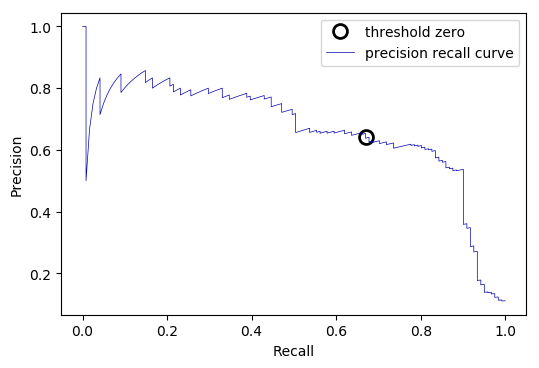

In [65]:
# create a similar dataset as before, but with more samples
# to get a smoother curve
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(recall, precision, label="precision recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

#### Model selection

- Different classifiers work best in different parts of the curve (at different operating points)
- Let's compare two classifiers (we'll see both soon)
- The RandomForest (in red) performs better at the extremes
- The area under the precision-recall curve (AUPRC) is often used as a general evaluation measure

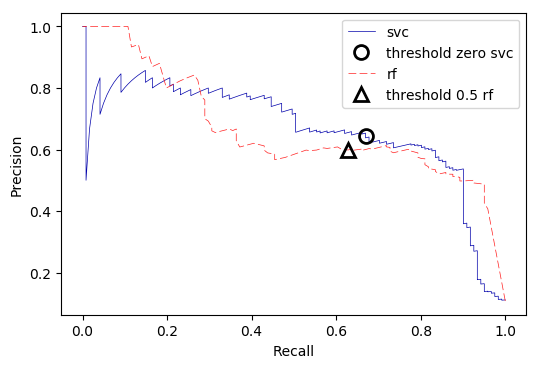

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
# Only pass probabilities for the positive class
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(recall, precision, label="svc")

plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(recall_rf, precision_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot( recall_rf[close_default_rf], precision_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

Note that the F1-measure completely misses these subtleties

In [67]:
print("f1_score of random forest: {:.3f}".format(
        f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


- The area under the precision-recall curve is returned by the `average_precision_score` measure 
    - It's actually a close approximation of the actual area
- This is a good automatic measure, but also hides the subtleties

In [68]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.666
Average precision of svc: 0.663


### Receiver Operating Characteristics (ROC) and AUC

- There is another trade-off between recall (true positive rate, TPR) and the false positive rate (FPR).
- The 2D space created by TPR and FPR is called the Receiver Operating Characteristics (ROC) space
- A model will be at one point in this ROC space

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

- Varying the decision threshold yields the ROC curve
- It can be computed with the `roc_curve` function
- Ideal is close to the top left: high recall, low FPR
- Inspect the curve to find the preferred calibration
    - Here, we can get much higher recall with slightly worse FPR

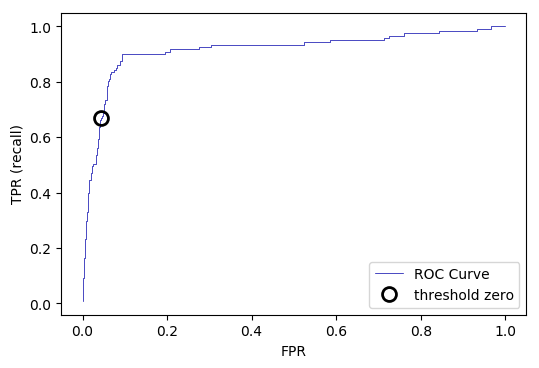

In [69]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

#### Visualization

- Imagine 2 overlapping distributions (positive red class, negative blue class)
- All points to the right of the threshold are predicted positive, others negative
- As we increase the threshold, we'll get fewer FPs, more FNs
    - Perfect classifier would perfectly separate the classes
    - For a random classifier, the distributions overlap completely

![roc](images/03_roc.png)

#### ROC Isometrics
- Different _costs_ can be involved for FP and FN
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost in minimal
    - If a FP and FN are weigthed equally, cost lines follow the diagonal (blue line)
    - If a FP is 10 times worse than a FN: pink line
    - IF a FN is 10 times worse than a FP: red line

![ROC cost curves](images/03_roc_cost.png)

#### Model selection

- Again, we can compare multiple models by looking at the ROC curves
- We can calibrate the threshold depending on whether we need high recall or low FPR
- We can select between algorithms (or hyperparameters) depending on the involved costs.

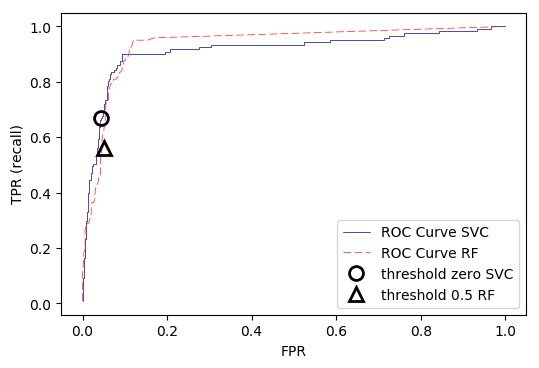

In [70]:
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);

#### Area under the ROC curve

- A good summary measure is the area under the ROC curve (AUROC or AUC)
- Compute using the `roc_auc_score` 
    - Don't use `auc`

In [71]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


#### Imbalanced classes
- AUC is popular because it is insensitive to class imbalance
    - Random guessing yields TPR=FPR no matter what the class imbalance is
    - All points are on the diagonal line, hence an AUC of 0.5
    - Hint: use the visualization of TPR,FPR to see this
- Example: unbalanced digits
    - 3 models, ACC is the same, AUC not
    - If we optimize for ACC, our model could be just random guessing

gamma = 1.000  accuracy = 0.90  AUC = 0.5000
gamma = 0.100  accuracy = 0.90  AUC = 0.9582
gamma = 0.010  accuracy = 0.90  AUC = 0.9995


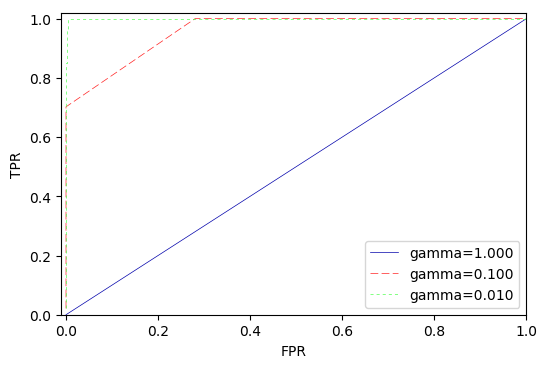

In [72]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.3f}  accuracy = {:.2f}  AUC = {:.4f}".format(
            gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

#### Take home message

- AUC is highly recommended, especially on imbalanced data
- Remember to calibrate the threshold to your needs

### Multi-class classification

- Multiclass metrics are derived from binary metrics, averaged over all classes
- Let's consider the full (10-class) handwritten digit recognition data

Confusion matrix

In [73]:
from sklearn.metrics import accuracy_score
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


Visualized as a heatmap

- Which digits are easy to predict? Which ones are confused? 

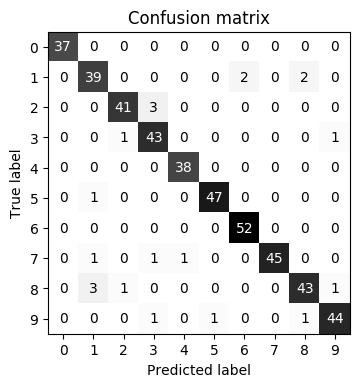

In [74]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Precision, recall, F1-score

- Now yield 10 per-class scores

In [75]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



Different ways to compute average

- macro-averaging: computes unweighted per-class scores: 
$\frac{\sum_{i=0}^{n}score_i}{n}$
    - Use when you care about each class equally much

- weighted averaging: scores are weighted by the relative size of the classes (support): 
$\frac{\sum_{i=0}^{n}score_i weight_i}{n}$
    - Use when data is imbalanced

- micro-averaging: computes total number of FP, FN, TP over all classes, them computes scores using these counts: 
$recall = \frac{\sum_{i=0}^{n}TP_i}{\sum_{i=0}^{n}TP_i + \sum_{i=0}^{n}FN_i}$
    - Use when you care about each sample equally much

In [76]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred, average="weighted")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Weighted average f1 score: 0.953
Macro average f1 score: 0.954


## Regression metrics

Most commonly used are
- (root) mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors
- R squared (r2)
    - Ratio of variation explained by the model / total variation
    - Always between 0 and 1, easier to interpret (higher is better)
    - Does not measure bias. Look at the residuals to make sure.

## Using evaluation metrics in model selection

- You typically want to use AUC or other relevant measures in `cross_val_score` and `GridSearchCV` instead of the default accuracy.
- scikit-learn makes this easy through the `scoring` argument
    - But, you need to need to look the [mapping between the scorer and the metric](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

![scorers](images/03_scoring.png)

Or simply look up like this:

In [77]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']


Cross-validation with accuracy and AUC

In [80]:
# default scoring for classification is accuracy
print("Default scoring: {}".format(
      cross_val_score(SVC(), digits.data, digits.target == 9)))
# providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9, 
                                     scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [ 0.9  0.9  0.9]
Explicit accuracy scoring: [ 0.9  0.9  0.9]
AUC scoring: [ 0.994  0.99   0.996]


Grid Search with accuracy and AUC

- With accuracy, gamma=0.0001 is selected
- With AUC, gamma=0.01 is selected
    - Actually has better accuracy on the test set

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


# Summary

- k-fold Cross-validation
    - Choose k depending on how much data you have
        - Larger k is slower, but allows more training data
        - 10-fold, 5-fold, 5x2-fold most popular
    - Always use stratification for (imbalanced) classification
    - Train-test split and Shuffle-split: useful for large datasets 
    - Use grouping when you want to generalize over groups
- Model selection
    - Don't aggregate over test scores: those have seen the test data
    - Use validation sets to choose algorithms/hyperparameters first
- Optimization
    - Grid Search: exhaustive but simple
    - Random Search: scales better
    - Model-based optimization: more efficient, scales better
- Evaluation measures
    - High accuracy is seldom the true goal
    - Choose metric depending on how you will use the model
    - Real world data is often imbalanced, has different costs for FP, FN